In [1]:
import numpy as np
from pina import Trainer, Condition, LabelTensor
from pina.solver import GAROM
from pina.callback import MetricTracker
from pina.model import FeedForward
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pina.problem.zoo import SupervisedProblem

KeyboardInterrupt: 

In [40]:
class Generator(nn.Module):

    def __init__(
        self,
        input_dimension=1,
        parameters_dimension=1,
        noise_dimension=1,
        activation=torch.nn.SiLU,
    ):
        super().__init__()

        self._noise_dimension = noise_dimension
        self._activation = activation
        self.model = FeedForward(6 * noise_dimension, input_dimension)
        self.condition = FeedForward(parameters_dimension, 5 * noise_dimension)
        self.parameters_dimension = parameters_dimension

    def forward(self, param):
        # uniform sampling in [-1, 1]
        z = (
            2
            * torch.rand(
                size=(param.shape[0], self._noise_dimension),
                device=param.device,
                dtype=param.dtype,
                requires_grad=True,
            )
            - 1
        )
        return self.model(torch.cat((z, self.condition(param.reshape(-1, self.parameters_dimension))), dim=-1))



In [41]:

class Discriminator(nn.Module):

    def __init__(
        self,
        input_dimension=1,
        parameter_dimension=1,
        hidden_dimension=2,
        activation=torch.nn.ReLU,
    ):
        super().__init__()

        self._activation = activation
        self.encoding = FeedForward(input_dimension, hidden_dimension)
        self.decoding = FeedForward(2 * hidden_dimension, 1)
        self.condition = FeedForward(parameter_dimension, hidden_dimension)
        self.parameter_dimension = parameter_dimension

    def forward(self, data):
        x, condition = data
        encoding = self.encoding(x)
        conditioning = torch.cat((encoding, self.condition(condition.reshape(-1,self.parameter_dimension))), dim=-1)
        decoding = self.decoding(conditioning)
        return decoding


In [42]:

# Generate 10 noisy sine wave data of dimension 100
DIM = 100
SAMPLES = 20

x = np.linspace(0, 2 * np.pi, DIM)
param = np.linspace(0, 20, SAMPLES)

# Generate y for each frequency with noise
# x_array = []
y_array = []
for freq in param:
    noise = 0.1 * np.random.normal(size=x.shape)
    y = np.sin(freq * x) + noise
    y_array.append(y)
    # x_array.append(x)

# x_array = np.array(x_array)
y_array = np.array(y_array)  # Shape: (len(param), dim)


# predict clean signal given noise signal (denoise)
problem = SupervisedProblem(
    torch.tensor(param, dtype=torch.float32),
    torch.tensor(y_array, dtype=torch.float32),
)


generator = Generator(input_dimension=DIM, parameters_dimension=1)
discriminator = Discriminator(input_dimension=DIM, parameter_dimension=1)

solver = GAROM(problem, generator, discriminator)

In [43]:

trainer = Trainer(
    solver=solver,
    max_epochs=4500,
    logger=True,
    callbacks=[MetricTracker()],
    accelerator="cpu",
    train_size=0.7,
    test_size=0.2,
    val_size=0.1,
    enable_model_summary=False,

)

trainer.train()


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 59.78it/s, v_num=96]            
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 77.01it/s, v_num=96, val_loss=0.659, d_loss=0.601, g_loss=0.169, stability_metric=0.607, data_loss=0.610, train_loss=0.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 90.58it/s, v_num=96, val_loss=0.654, d_loss=0.600, g_loss=0.160, stability_metric=0.615, data_loss=0.609, train_loss=0.609]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 96.67it/s, v_num=96, val_loss=0.649, d_loss=0.599, g_loss=0.153, stability_metric=0.616, data_loss=0.608, train_loss=0.608] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 91.91i


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/zgdi/anaconda3/envs/ml/lib/python3.12/site-packages/IPython/core/interactiveshell.py: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.


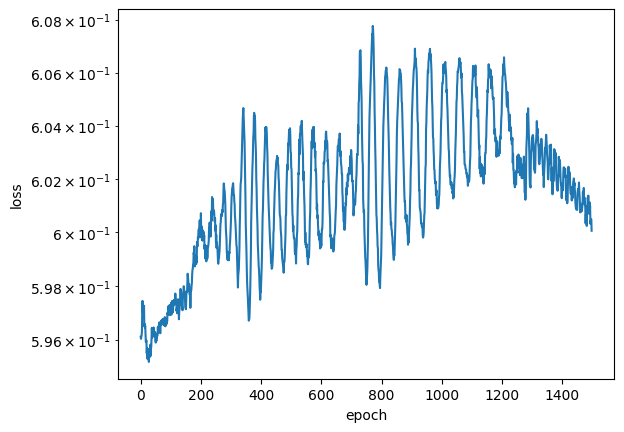

In [37]:

# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss"]
epochs = range(len(loss))

plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

all_outputs = []
all_targets = []
all_inputs = []
trainer.data_module.setup("test")
with torch.no_grad():
    for data in trainer.data_module.test_dataloader():
        # for data in trainer.data_module.train_dataloader():
        inputs, target = data[0][1]["input"], data[0][1]["target"]
        outputs = solver(inputs)
        all_inputs.append(inputs)
        all_outputs.append(outputs)
        all_targets.append(target)
        break


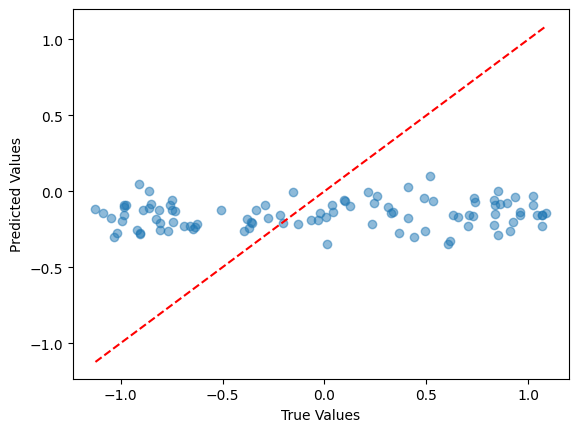

In [38]:
# plot targets vs predictions for validation set
y_mean = torch.stack(all_outputs, dim=0).detach()
true_output = torch.stack(all_targets, dim=0).detach()


# use 3 columns per row
i=0
plt.scatter(true_output[:, i], y_mean[:, i], alpha=0.5)
plt.plot(
    [true_output[:, i].min(), true_output[:, i].max()],
    [true_output[:, i].min(), true_output[:, i].max()],
    "r--",
)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()